In [2]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import tmap
import geodatasets

In [3]:
path = "./data/"
file_name = ['chicago_2019.csv', 'chicago_2020.csv', 'chicago_2021.csv', 'chicago_2022.csv']
filenames =[path + file for file in file_name]

""" 
    Modifies: df
    Read Me: Basic File Merger, to combine the 2019-2022 census data
    Requires: A file path list, file path may need to be modified accordingly, to fit folder structure
"""
def fileMerger(path):
    df1 = pd.read_csv(path[0])
    df2 = pd.read_csv(path[1])
    df_merged = df1.merge(df2, how='outer')
    for file in path[2:]:
        temp = pd.read_csv(file)
        df_merged = df_merged.merge(temp, how='outer')
    return df_merged

df = fileMerger(filenames)

# access the processed place of interest data
walkability = pd.read_csv("./data/poi_data_processed.csv")
walkability = walkability.drop(['Unnamed: 0'], axis=1)
if walkability.shape[1] == 3:
    print(f"Success loading a dataframe with {df.shape[0]} rows.")
    print(df.shape, walkability.shape)

Success loading a dataframe with 922195 rows.
(922195, 22) (77, 3)


In [4]:
# Converting Community Area Code to an Community Name
"""
This allows us to explore data much effectively, being able
to scrape further information outside of just a code, such as
exploring real estate property indices in each community, and
make inferences regarding average home sale price and its corresponding community.
"""
import requests
url = "https://www.chicagotribune.com/2002/12/04/chicago-communities-17/"
text = requests.get(url).text

tables = pd.read_html(url)
print("Found {} tables in Source[{}]".format(len(tables), url))
hash = {"Community Area" : ["nan", "nan"], "Community Name": ["NaN", "NaN"]}

community = tables[1]

for item in (community):
    # community index
    if(item == 0 or item == 2):
        for i in range(len(community[item])):
                community[item] = community[item].astype(float)
                hash['Community Area'].append(community[item][i])
    if(item == 1 or item == 3):
        for i in range(len(community[item])):
                community[item] = community[item].astype(str)
                #print(community[item][i])
                hash['Community Name'].append(community[item][i])

def applyName(x):
    for item in range(len(hash["Community Area"])):
        if x == hash["Community Area"][item]:
            return hash["Community Name"][item].upper()
df["Community Name"] = df['Community Area'].apply(applyName)

# Check the Community Name Output
df['Community Name'] 

Found 4 tables in Source[https://www.chicagotribune.com/2002/12/04/chicago-communities-17/]


0                 CHATHAM
1           HUMBOLDT PARK
2          LINCOLN SQUARE
3               EDGEWATER
4                 CHATHAM
               ...       
922190          EDGEWATER
922191    LOWER WEST SIDE
922192           ROSELAND
922193     SOUTH LAWNDALE
922194       WEST PULLMAN
Name: Community Name, Length: 922195, dtype: object

In [5]:
%%time
"""Quantify the Sum of Violent Crimes"""
violent_crimes = ['HOMICIDE', 'ASSAULT', 'BATTERY', 'SEXUAL ASSAULT', 'ARSON']

violent_data = df[df['Primary Type'].isin(violent_crimes)]
non_violent_data = df[~df['Primary Type'].isin(violent_crimes)]

non_violent_crime_counts = non_violent_data.groupby('Community Name').size().reset_index(name='Non-Violent Crime Count')
violent_crime_counts = violent_data.groupby('Community Name').size().reset_index(name='Violent Crime Count')

df = pd.merge(df, violent_crime_counts, on='Community Name', how='left')
df = pd.merge(df, non_violent_crime_counts, on='Community Name', how='left')

df['Violent Crime Count'] = df['Violent Crime Count'].fillna(0)
df['Non-Violent Crime Count'] = df['Non-Violent Crime Count'].fillna(0)




CPU times: total: 406 ms
Wall time: 1.05 s


In [6]:
"""Quantify the Sum of Violent Crimes"""
theft = ['ROBBERY', "THEFT"]

theft = df[df['Primary Type'].isin(theft)]

theft_counts = theft.groupby('Community Name').size().reset_index(name='Theft Count')

df = pd.merge(df, theft_counts, on='Community Name', how='left')

df['Theft Count'] = df['Theft Count'].fillna(0)

In [7]:
theft_counts

,Community Name,Theft Count
0,ALBANY PARK,2224
1,ARCHER HEIGHTS,887
2,ARMOUR SQUARE,1323
3,ASHBURN,1630
4,AUBURN GRESHAM,4658
...,...,...
72,WEST LAWN,1633
73,WEST PULLMAN,2201
74,WEST RIDGE,3819
75,WEST TOWN,10472


In [8]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Name', 'Violent Crime Count',
       'Non-Violent Crime Count', 'Theft Count'],
      dtype='object')

In [9]:
census_tract = pd.read_csv("./data/census.csv")
census_tract['COMMUNITY AREA NAME'] = census_tract['COMMUNITY AREA NAME'].str.upper()
df = pd.merge(df, census_tract, how='inner', left_on='Community Name', right_on='COMMUNITY AREA NAME')

df_clean = df.dropna()
print(f"Data Loss: {(df.shape[0] / df_clean.shape[0]):.3f}%")

Data Loss: 1.022%


In [10]:
zest = pd.read_csv("./data/chicago_zestimate.csv")

In [11]:
zest = pd.read_csv("./data/chicago_zestimate.csv")
price_columns = [col for col in zest.columns if '2019' in col or '2020' in col or '2021' in col or '2022' in col]
zest = zest[['RegionName', 'City', 'CountyName'] + price_columns]
zest['RegionName'] = zest['RegionName'].str.upper()
zest.head()

,RegionName,City,CountyName,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,LAKE VIEW,Chicago,Cook County,333262.893331,333278.604769,333159.087955,333365.464322,333150.964329,332522.898324,331346.207891,...,358877.250743,361622.126764,363112.489629,364289.431955,364124.934501,363401.361238,361142.692643,359309.310794,358529.881026,358133.980258
1,WEST RIDGE,Chicago,Cook County,210356.304189,211286.998448,211642.602063,211674.832316,211251.531300,211091.222693,210650.452888,...,231953.822356,234806.681696,236222.328121,236021.672160,234360.969394,232598.410214,231108.551888,230292.048787,230160.567318,229586.620660
2,LITTLE VILLAGE,Chicago,Cook County,124221.082388,125158.782704,125980.205142,127265.562221,128022.286047,128634.687191,128200.267419,...,178650.017511,181989.638994,183150.892915,183157.300717,181266.796972,178393.510259,174783.617930,172322.533397,171107.068272,170162.508506
3,LOGAN SQUARE,Chicago,Cook County,411911.303193,414139.429696,416217.979092,417807.574106,417492.253511,416006.833953,413772.411268,...,458508.968749,460201.881217,461460.728586,462130.297270,461001.486930,458041.098967,453345.161241,449320.430127,446835.406030,445014.473892
4,LINCOLN PARK,Chicago,Cook County,537661.450262,538645.015911,538123.226706,536740.662908,533736.288756,531955.269122,530461.129855,...,549085.119358,556030.310045,560320.231032,563334.422330,562856.693289,560760.585573,556100.364536,552691.122090,551142.462888,550744.931644


In [12]:
chicago = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))
chicago = pd.merge(chicago, zest, right_on="RegionName", left_on ="community", how = "left")

<Axes: >

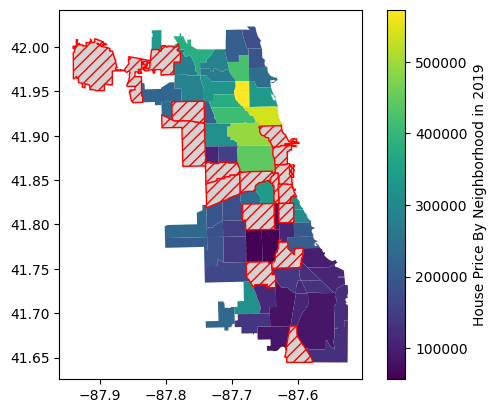

In [13]:
chicago.plot(
    column="2019-01-31",
    legend=True,
    legend_kwds={"label": "House Price By Neighborhood in 2019", "orientation": "vertical"},
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
)

In [14]:
nan_rows = chicago[chicago['RegionName'].isna()]
target = nan_rows['community'].unique().tolist()
target # <- go to scraper.ipynb to scrape prices for these communiites, then apply back into the data set.

['DOUGLAS',
 'GRAND BOULEVARD',
 'BELMONT CRAGIN',
 'AUSTIN',
 'NORTH LAWNDALE',
 'SOUTH LAWNDALE',
 'LOWER WEST SIDE',
 'NEAR SOUTH SIDE',
 'ARMOUR SQUARE',
 'NORWOOD PARK',
 'NEAR NORTH SIDE',
 'LOOP',
 'RIVERDALE',
 'NEW CITY',
 'GREATER GRAND CROSSING',
 'AUBURN GRESHAM',
 'OHARE']

C:\Users\Shpig\AppData\Local\Temp\ipykernel_22164\3646118857.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago['Price'][i] = (chicago['2022-12-31'][i] + chicago['2019-01-31'][i]) / 2


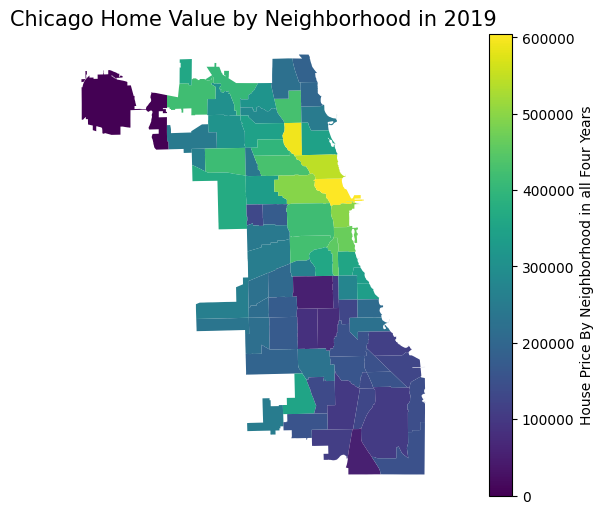

In [15]:
missing = pd.read_csv('data/missing_home_prices.csv')
chicago['average'] = 0
chicago = pd.merge(chicago, missing, right_on="Community Name", left_on ="community", how = "left")

# apply rough price mean in 4-year span
for i, price in enumerate(chicago['Price']):
    if pd.isna(price):
        chicago['Price'][i] = (chicago['2022-12-31'][i] + chicago['2019-01-31'][i]) / 2

# Updated Chicago Housing Plot (2019-2022)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
chicago.plot(
    column="Price",
    legend=True,
    legend_kwds={
        "label": "House Price By Neighborhood in all Four Years",
        "orientation": "vertical"
    },
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    },
    cmap='viridis',
    ax=ax
)

ax.set_title("Chicago Home Value by Neighborhood in 2019", fontsize=15) 
ax.set_axis_off()
plt.show()

In [16]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Name', 'Violent Crime Count',
       'Non-Violent Crime Count', 'Theft Count', 'Community Area Number',
       'COMMUNITY AREA NAME', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX'],
      dtype='object')

In [17]:
df = df[['Community Name', 'Violent Crime Count', "Non-Violent Crime Count", "Theft Count", 'PERCENT OF HOUSING CROWDED',
         'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
         'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 'PERCENT AGED UNDER 18 OR OVER 64',
         'PER CAPITA INCOME ', 'HARDSHIP INDEX']]
df.loc[:, 'Crime Count'] = 1
df_processed = df.groupby(['Community Name', 'Violent Crime Count', "Non-Violent Crime Count", 'PERCENT OF HOUSING CROWDED',
         'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
         'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 'PERCENT AGED UNDER 18 OR OVER 64',
         'PER CAPITA INCOME ', 'HARDSHIP INDEX']).sum().reset_index()

if (df_processed.shape[0] == 73):
    print('Process Success')
    df_processed.sort_values('Crime Count', ascending=True).head(4)

Process Success


In [18]:
chicago = pd.merge(chicago, df_processed, right_on="Community Name", left_on ="community", how = "left")
walkscore = pd.read_csv("./data/poi_data_processed.csv")
chicago = pd.merge(chicago, walkscore, right_on="Community Name", left_on ="community", how = "left")


In [19]:
chicago["scaled_walkability"] = chicago["scaled_walkability"].apply(lambda x: 1-x)

In [20]:
chicago.head(1)

,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry,RegionName,...,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Theft Count,Crime Count,Unnamed: 0,Community Name,Walk_Score,scaled_walkability
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",NaN,...,14.3,30.7,23791.0,47.0,26530608.0,10004.0,34,DOUGLAS,456.320397,0.533031


In [21]:
chicago["crimevspop"] = chicago["Violent Crime Count"] / chicago["POP2010"]

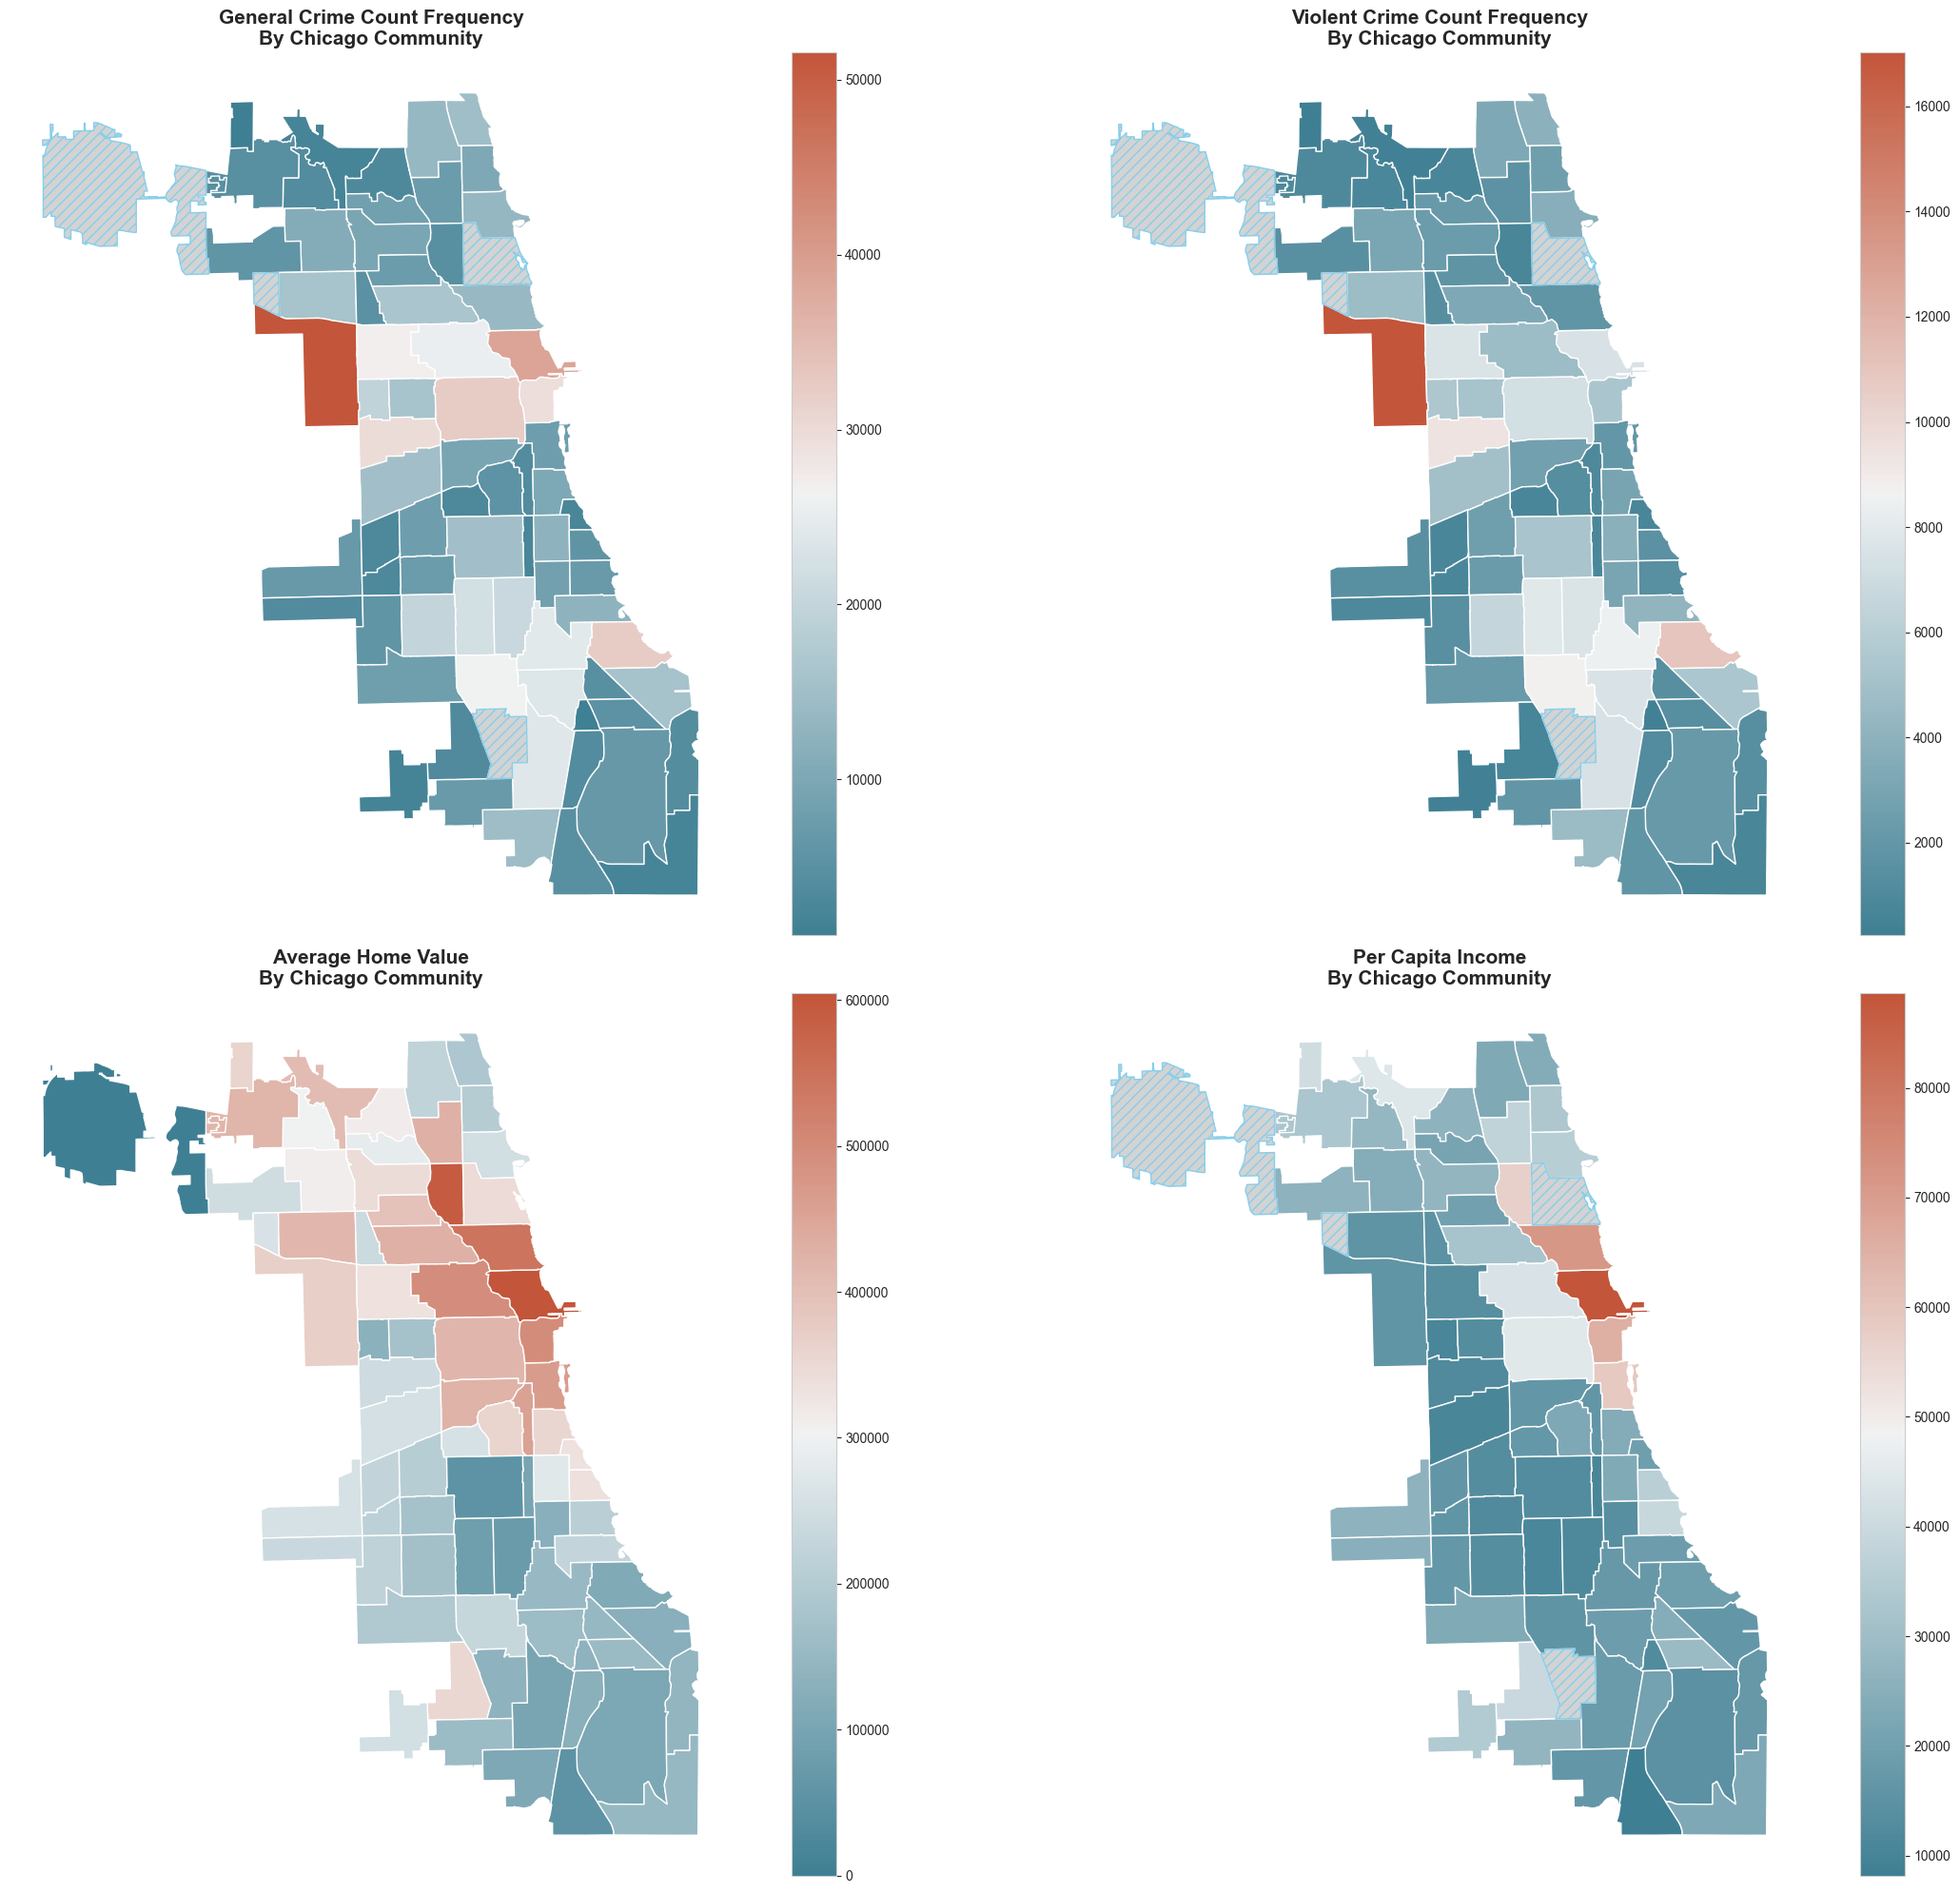

In [22]:

sb.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(24, 20))

# function that 'automates' the process
def plot_data(ax, column, title, cmap):
    chicago.plot(
        column=column,
        legend=True,
        cmap=cmap,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "skyblue",
            "hatch": "///",
            "label": "Missing values"
        },
        ax=ax

    )
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_axis_off()
cmap = sb.diverging_palette(220, 20, as_cmap=True)
# Plot each data on a specific subplot axis
plot_data(axes[0, 0], "Crime Count", "General Crime Count Frequency\nBy Chicago Community", cmap)
plot_data(axes[0, 1], "Violent Crime Count", "Violent Crime Count Frequency\nBy Chicago Community", cmap)
plot_data(axes[1, 0], "Price", "Average Home Value\nBy Chicago Community", cmap)
plot_data(axes[1, 1], "PER CAPITA INCOME ", "Per Capita Income\nBy Chicago Community", cmap)
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()


In [23]:
chicago.columns

Index(['community', 'NID', 'POP2010', 'POP2000', 'POPCH', 'POPPERCH',
       'popplus', 'popneg', 'geometry', 'RegionName', 'City', 'CountyName',
       '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
       '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
       '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
       '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
       '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
       '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
       '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
       '2022-10-31', '2022-11-30', '2022-12-31', 'average', 'Community Name_x',
       'Price', 'Community Name_y', 'Violent Crime Count',
       'Non-Violent Cr

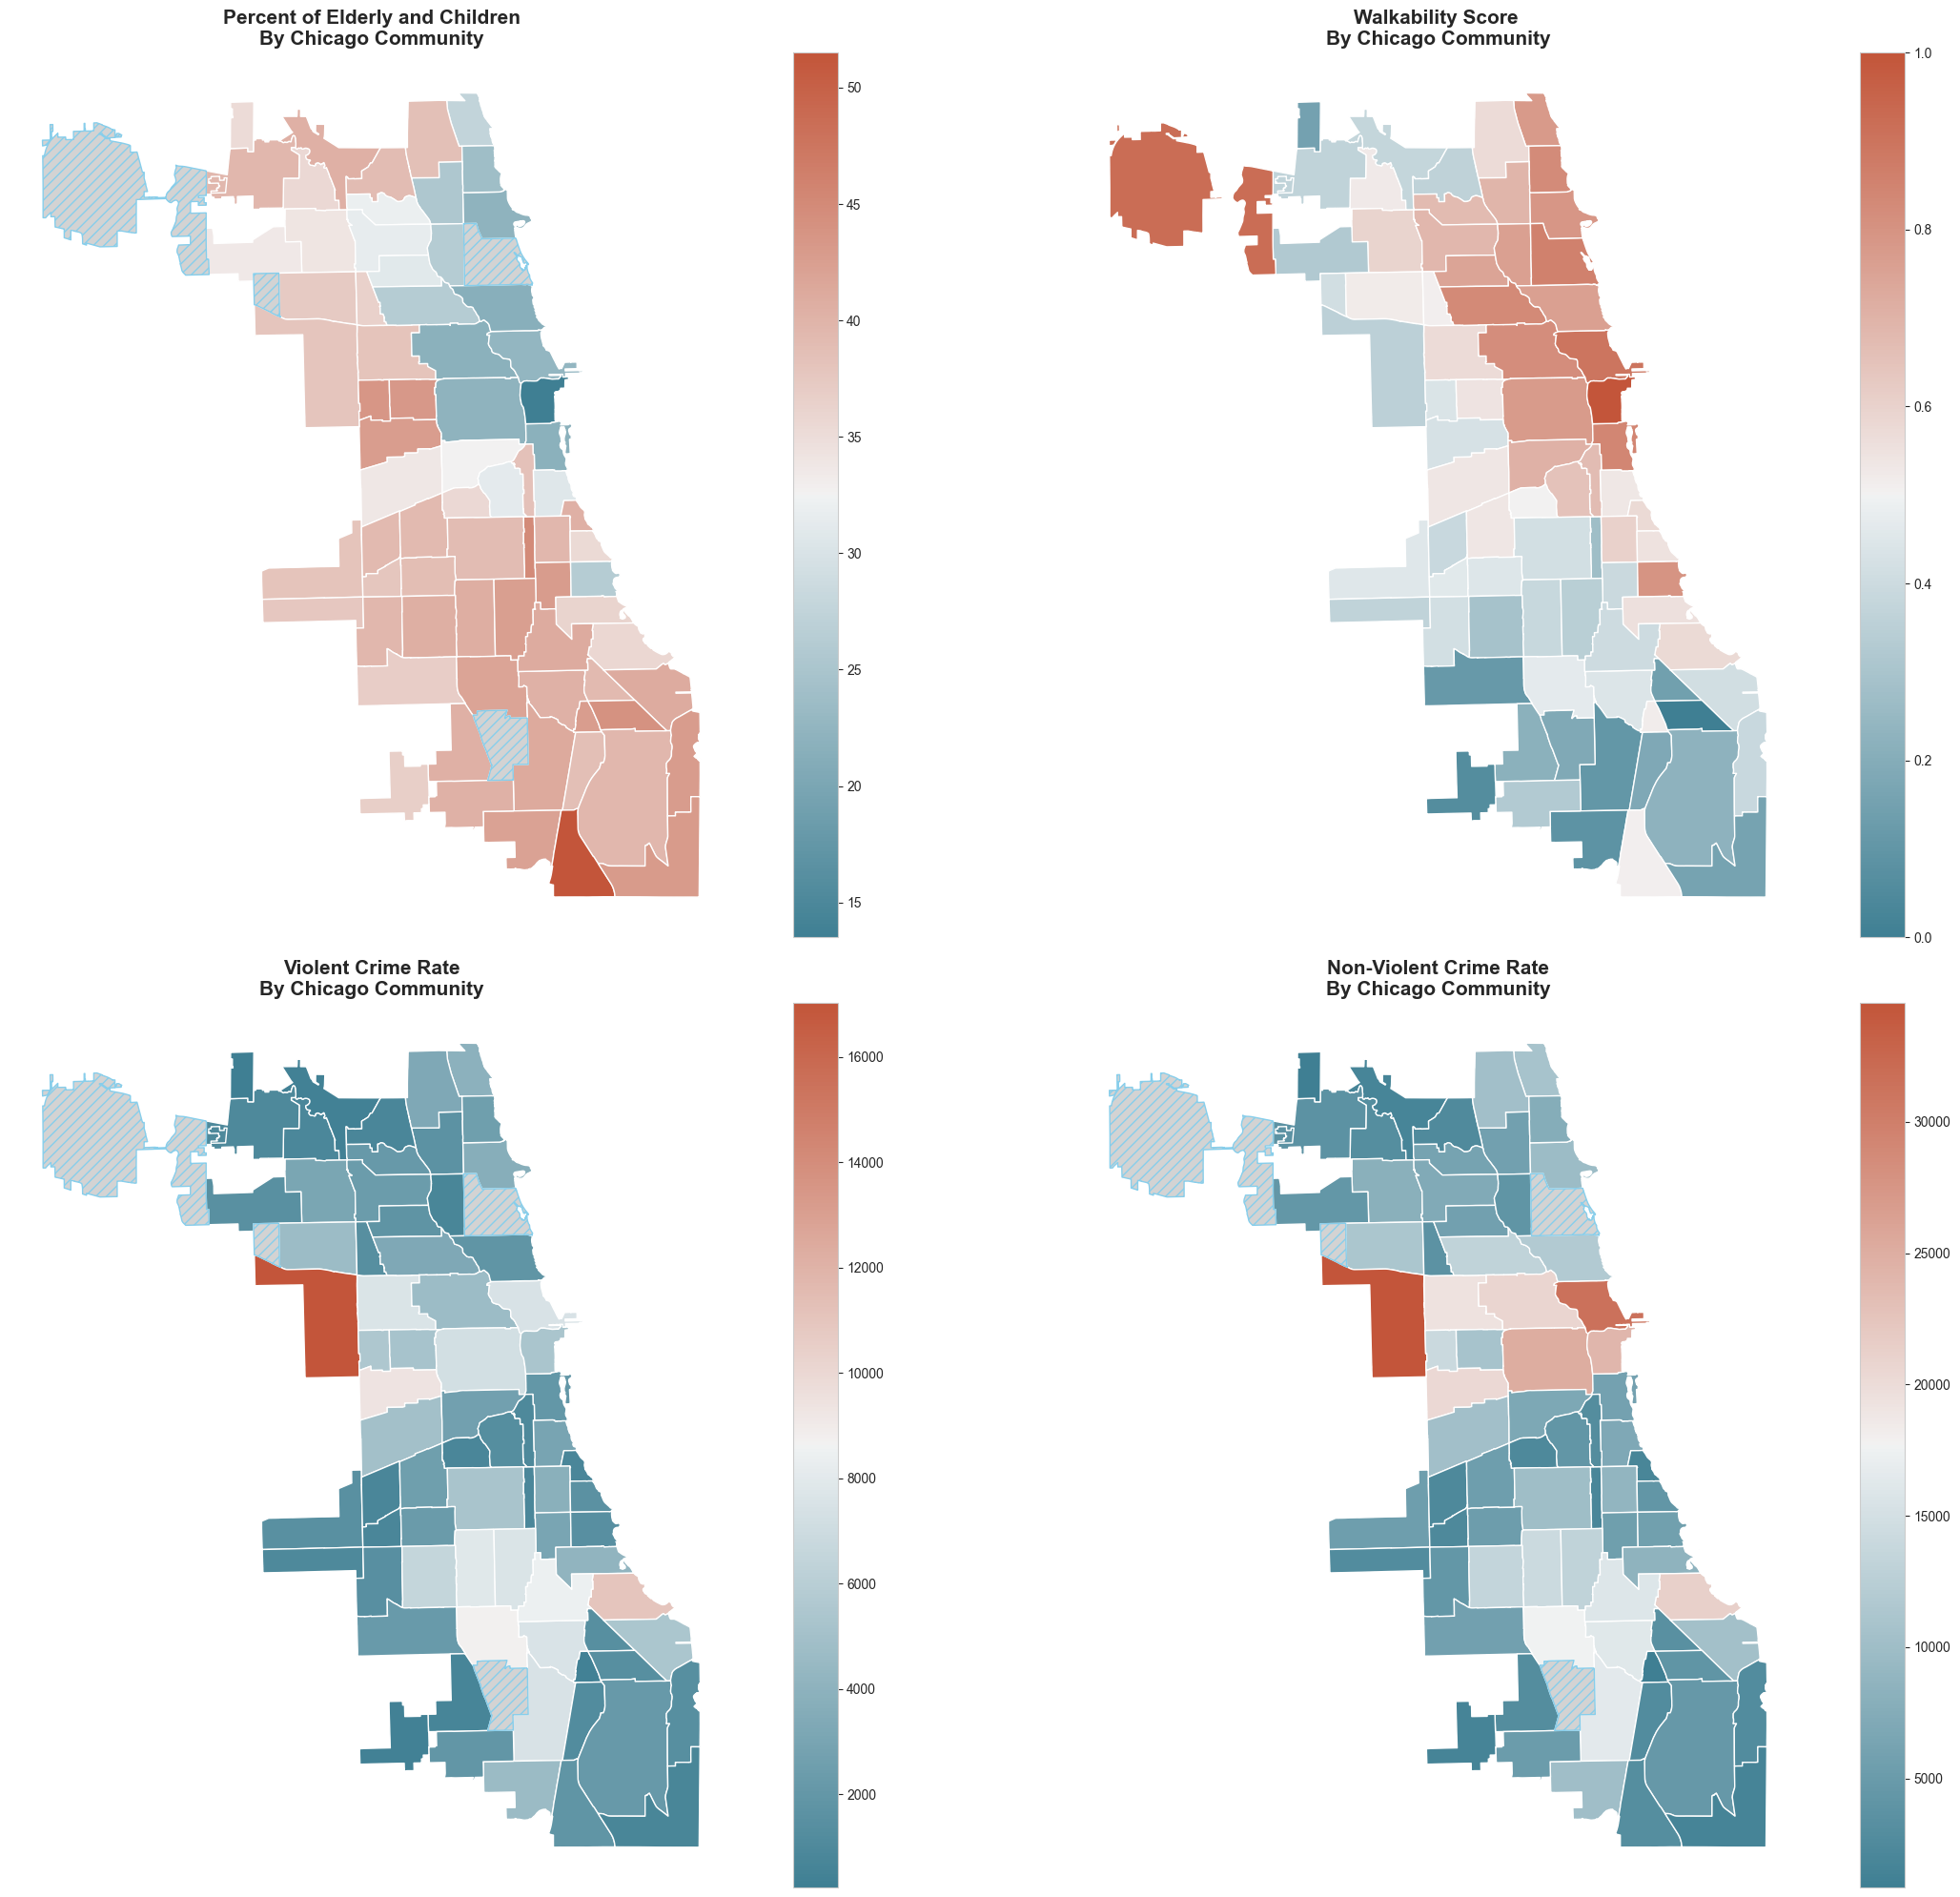

In [30]:
sb.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(24, 20))

# function that 'automates' the process
def plot_data(ax, column, title, cmap):
    chicago.plot(
        column=column,
        legend=True,
        cmap=cmap,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "skyblue",
            "hatch": "///",
            "label": "Missing values"
        },
        ax=ax

    )
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_axis_off()
cmap = sb.diverging_palette(220, 20, as_cmap=True)
# Plot each data on a specific subplot axis
plot_data(axes[0, 0], "PERCENT AGED UNDER 18 OR OVER 64", "Percent of Elderly and Children\nBy Chicago Community", cmap)
plot_data(axes[0, 1], "scaled_walkability", "Walkability Score \nBy Chicago Community", cmap)
plot_data(axes[1, 0], "Violent Crime Count", "Violent Crime Rate\nBy Chicago Community", cmap)
plot_data(axes[1, 1], "Non-Violent Crime Count", "Non-Violent Crime Rate\nBy Chicago Community", cmap)
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()


In [25]:
chicago.columns

Index(['community', 'NID', 'POP2010', 'POP2000', 'POPCH', 'POPPERCH',
       'popplus', 'popneg', 'geometry', 'RegionName', 'City', 'CountyName',
       '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
       '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
       '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
       '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
       '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
       '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
       '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
       '2022-10-31', '2022-11-30', '2022-12-31', 'average', 'Community Name_x',
       'Price', 'Community Name_y', 'Violent Crime Count',
       'Non-Violent Cr

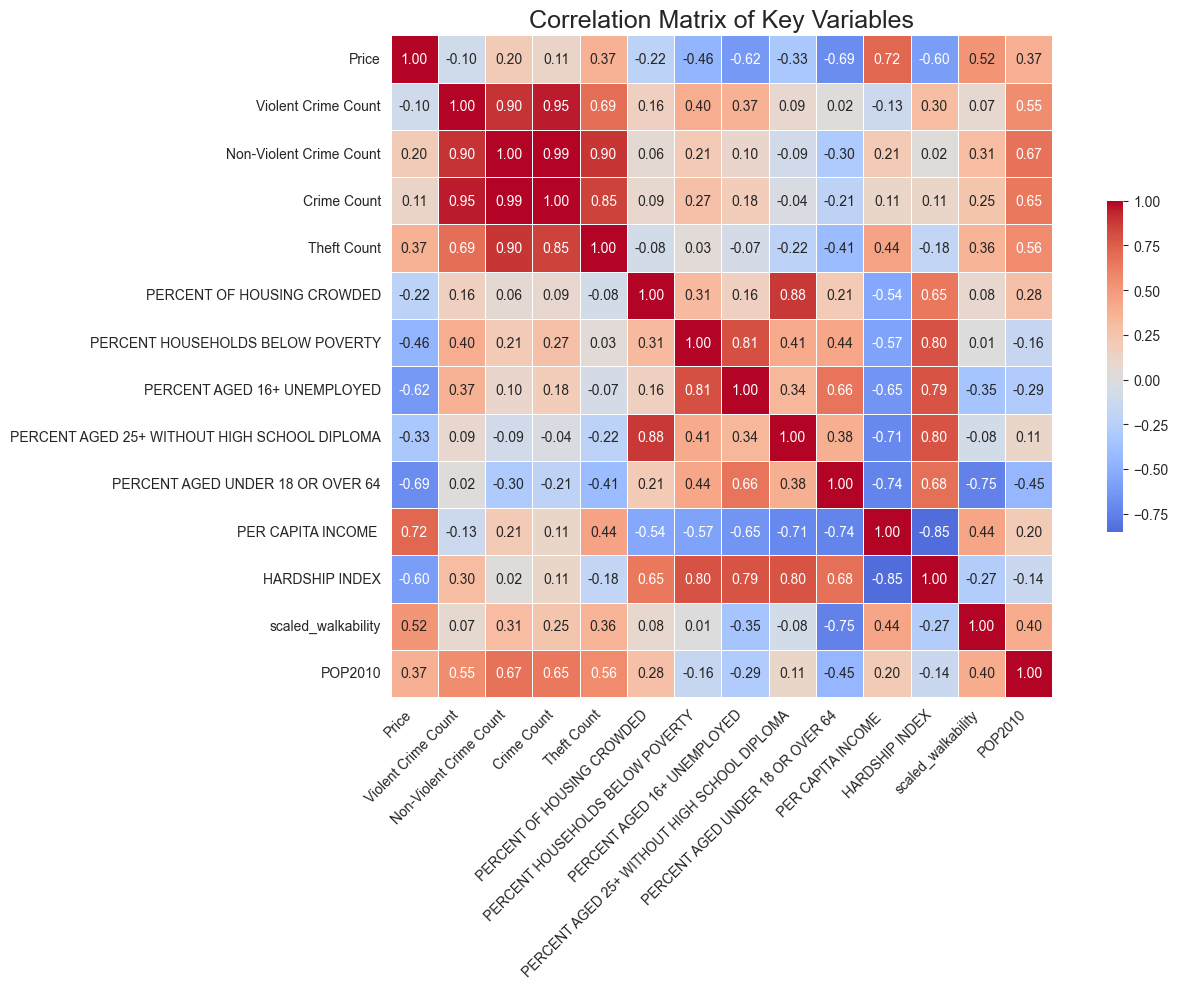

In [26]:
target = [
    'Price', 'Violent Crime Count', "Non-Violent Crime Count", 'Crime Count','Theft Count', 'PERCENT OF HOUSING CROWDED',
    'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
    'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 'PERCENT AGED UNDER 18 OR OVER 64',
    'PER CAPITA INCOME ', 'HARDSHIP INDEX', 'scaled_walkability', "POP2010" # Space after 'PER CAPITA INCOME ' corrected
]

target_corr = chicago[target].corr()
plt.figure(figsize=(14, 10))
sb.heatmap(target_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix of Key Variables', size=18)
plt.tight_layout()
plt.show()

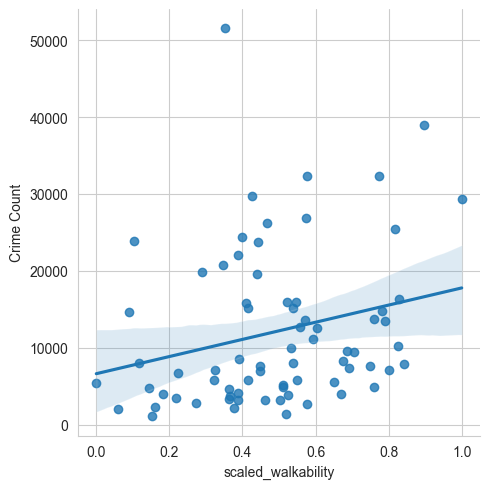

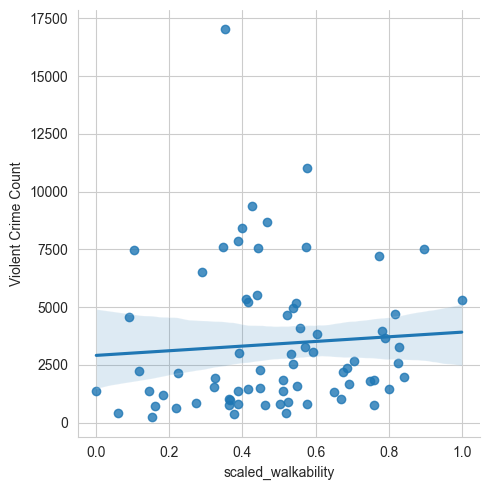

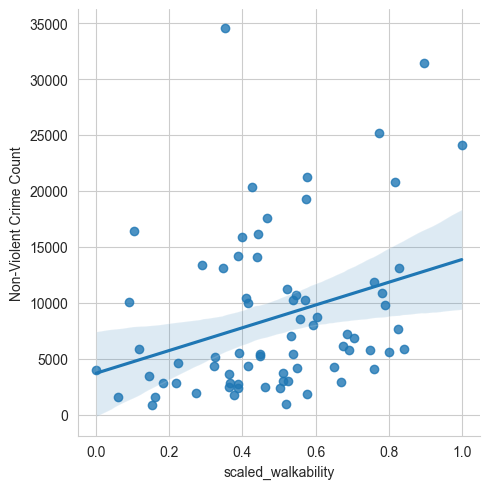

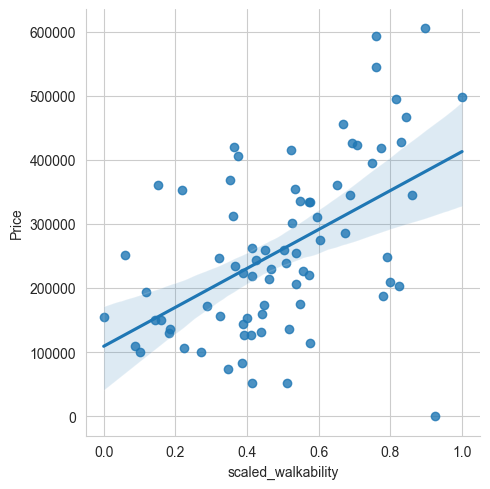

In [27]:
sb.lmplot(data=chicago, x="scaled_walkability", y="Crime Count")
sb.lmplot(data=chicago, x="scaled_walkability", y="Violent Crime Count")
sb.lmplot(data=chicago, x="scaled_walkability", y="Non-Violent Crime Count")
sb.lmplot(data=chicago, x="scaled_walkability", y="Price")


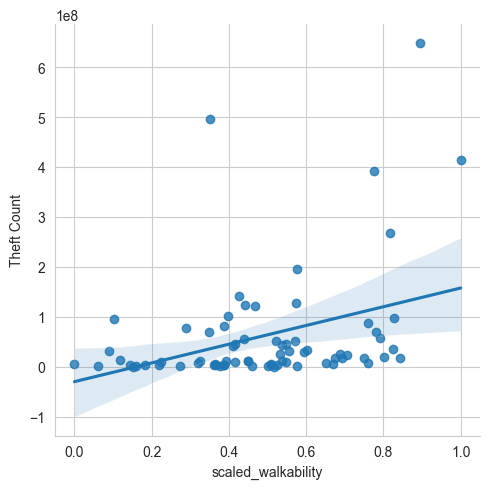

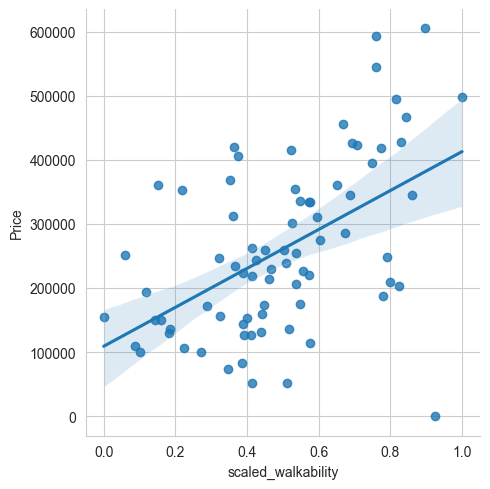

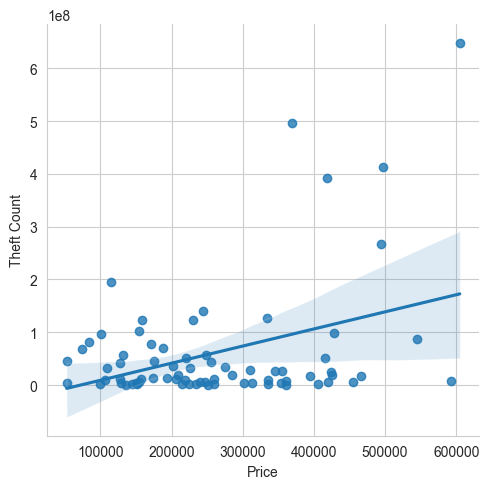

In [28]:
sb.lmplot(data=chicago, x="scaled_walkability", y="Theft Count")
sb.lmplot(data=chicago, x="scaled_walkability", y="Price")
sb.lmplot(data=chicago, x="Price", y="Theft Count")


